### Toxic Comment Classification - Machine Learning Nanodegree Capstone Project
 - It is a Multi-label classification task, where a collection of comments on Wikipedia articles were classified into one or more of the following labels: Toxic, Sever Toxic, Obscene, Threat, Insult, Identity hate. 
 - The model uses a Supervised Machine Learning algorithm called Decision Tree. 
 - Its performance is evaluated by ROC & AUC scoring method, which resulted in ~71% prediction accuracy. 

### Import all the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import string
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

### Load the data in

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train_nan = train.isnull().sum().sum()
test_nan = test.isnull().sum().sum()
print(train_nan)
print(test_nan)

# the dataset has 0 Nan, so there's no missing values to deal with. 

0
0


### Visualize the tabular format of the data

In [4]:
print('train shape', train.shape)
train.head()

train shape (159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
print('test shape', test.shape)
test.head()

test shape (153164, 2)


,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [6]:
Non_Toxic, Toxic = train.toxic.value_counts()
Non_Severe_Toxic, Severe_Toxic = train.severe_toxic.value_counts()
Not_Obscene, Obscene = train.obscene.value_counts()
Not_Threat, Threat = train.threat.value_counts()
Not_Insult, Insult = train.insult.value_counts()
Not_Identity_Hate, Identity_Hate = train.identity_hate.value_counts()

print ("Toxic Comments: {}".format(Toxic))
print ("Non-Toxic Comments: {} \n".format(Non_Toxic))
print ("Sever Toxic Comments: {}".format(Severe_Toxic))
print ("Non-Severe Toxic Comments: {} \n".format(Non_Severe_Toxic))
print ("Obscene Comments: {}".format(Obscene))
print ("Not_Obscene Comments: {} \n".format(Not_Obscene))
print ("Threat Comments: {}".format(Threat))
print ("Not Threat Comments: {} \n".format(Not_Threat))
print ("Insult Comments: {}".format(Insult))
print ("Non-Insult Comments: {} \n".format(Not_Insult))
print ("Identity_Hate Comments: {}".format(Identity_Hate))
print ("Not-Identity_Hate Comments: {}".format(Not_Identity_Hate))

Toxic Comments: 15294
Non-Toxic Comments: 144277 

Sever Toxic Comments: 1595
Non-Severe Toxic Comments: 157976 

Obscene Comments: 8449
Not_Obscene Comments: 151122 

Threat Comments: 478
Not Threat Comments: 159093 

Insult Comments: 7877
Non-Insult Comments: 151694 

Identity_Hate Comments: 1405
Not-Identity_Hate Comments: 158166


### Percentage of each feature

In [7]:
features = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
train_features = train.loc[:,features]
train_percent = train_features.sum()/len(train)
display(train_percent)

toxic            0.095844
severe_toxic     0.009996
obscene          0.052948
threat           0.002996
insult           0.049364
identity_hate    0.008805
dtype: float64

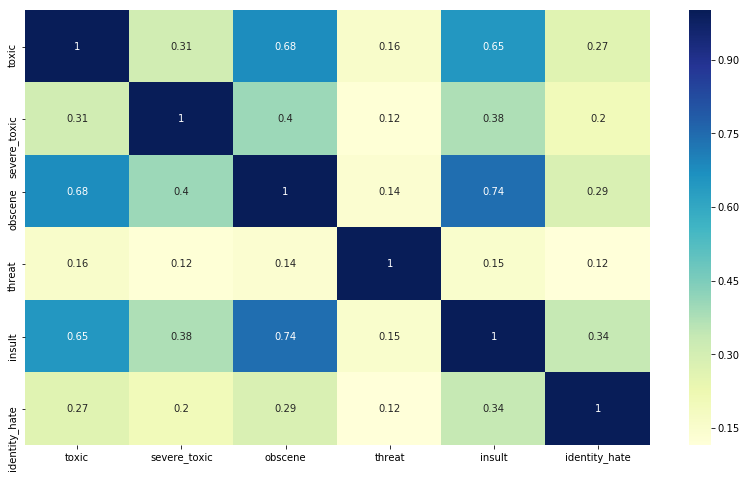

In [8]:
#Visualize the corrolation between the features in a heatmap
plt.figure(figsize=(14,8))
sns.heatmap(train.corr(),annot=True, cmap="YlGnBu")

### Normalizing & Tokenization of the comments
 - By removing non-alphanumeric characters, diacritical marks, regular expressions and transforming all letters to the lower form. 
 

In [9]:
#ceate function for normalizing the comments
def comments_normalize(df):
    df['comment_text'] = df['comment_text'].apply(lambda x: str(x))
    df['comment_text'] = df['comment_text'].apply(lambda x: x.lower())
    df['comment_text'] = df['comment_text'].apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))
    df['comment_text'] = df['comment_text'].apply(lambda x: x.replace('\n',''))
    df['comment_text'] = df['comment_text'].apply(lambda x: x.replace('\r',''))
    return df

train = comments_normalize(train)
test = comments_normalize(test)

### Data after Normalization

In [10]:
print('train shape', train.shape)
train.head()

train shape (159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanationwhy the edits made under my usernam...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww he matches this background colour im seem...,0,0,0,0,0,0
2,000113f07ec002fd,hey man im really not trying to edit war its j...,0,0,0,0,0,0
3,0001b41b1c6bb37e,morei cant make any real suggestions on improv...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0


In [11]:
print('test shape', test.shape)
test.head()

test shape (153164, 2)


,id,comment_text
0,00001cee341fdb12,yo bitch ja rule is more succesful then youll ...
1,0000247867823ef7,from rfc the title is fine as it is imo
2,00013b17ad220c46,sources zawe ashton on lapland —
3,00017563c3f7919a,if you have a look back at the source the info...
4,00017695ad8997eb,i dont anonymously edit articles at all


### Vectorization of the text data
 - By turning a collection of text documents into numerical feature vectors


In [12]:
vectorizer = TfidfVectorizer(stop_words='english')
vect_train_comments = vectorizer.fit_transform(train['comment_text'])

pd.DataFrame(vect_train_comments.sum(axis=0).T, index=vectorizer.get_feature_names())[0]\
    .sort_values(ascending=False)[:20]

article      3057.090261
page         2884.445414
talk         2634.319560
wikipedia    2201.580624
just         1951.449653
dont         1919.895658
like         1825.049362
im           1580.932209
thanks       1570.049187
edit         1555.745150
think        1511.057029
know         1496.911880
did          1356.790248
articles     1220.512918
people       1190.651135
use          1168.678104
time         1133.118205
good         1128.505718
editing      1117.715500
thank        1091.542278
Name: 0, dtype: float64

### Shuffle Split the data, then train three different predictive models

In [13]:
#shuffle split
train_x, test_x, train_y, test_y = train_test_split(vect_train_comments, train[features], test_size=0.33)

#fit the training data to three calssifiers
clf_A = DecisionTreeClassifier()
clf_A.fit(train_x, train_y)
clf_B = ExtraTreeClassifier()
clf_B.fit(train_x, train_y)

#predict on the evaluation set
predictions_A = clf_A.predict(test_x)
predictions_B = clf_B.predict(test_x)


In [14]:
from sklearn.ensemble import RandomForestClassifier

clf_C = RandomForestClassifier()
clf_C.fit(train_x, train_y)
predictions_C = clf_C.predict(test_x)

In [15]:
print(train_x.shape)
print(train_y.shape)

(106912, 301031)
(106912, 6)


### Compare the performance of the three models

In [16]:
my_metrics_A = metrics.classification_report(test_y, predictions_A)
ROC_AUC_A = roc_auc_score(test_y, predictions_A)
print('performnce metrics of the DecisionTree classifier:') 
print ("Metrics: \n {}".format(my_metrics_A))
print('ROC & AUC: {} \n ______________________________________ \n'. format(ROC_AUC_A))

my_metrics_B = metrics.classification_report(test_y, predictions_B)
ROC_AUC_B = roc_auc_score(test_y, predictions_B)
print('performnce metrics of the ExtraTree classifier:') 
print ("Metrics: \n {}".format(my_metrics_B))
print('ROC & AUC: {} \n ______________________________________ \n'. format(ROC_AUC_B))

my_metrics_C = metrics.classification_report(test_y, predictions_C)
ROC_AUC_C = roc_auc_score(test_y, predictions_C)
print('performnce metrics of the RandomForest classifier:') 
print ("Metrics: \n {}".format(my_metrics_C))
print('ROC & AUC: {}'. format(ROC_AUC_C))



performnce metrics of the DecisionTree classifier:
Metrics: 
              precision    recall  f1-score   support

          0       0.73      0.64      0.68      5085
          1       0.34      0.19      0.25       567
          2       0.77      0.73      0.75      2854
          3       0.27      0.17      0.21       150
          4       0.63      0.57      0.60      2658
          5       0.39      0.24      0.30       488

avg / total       0.68      0.60      0.64     11802

ROC & AUC: 0.7069122343305251 
 ______________________________________ 

performnce metrics of the ExtraTree classifier:
Metrics: 
              precision    recall  f1-score   support

          0       0.60      0.61      0.60      5085
          1       0.21      0.17      0.19       567
          2       0.56      0.57      0.57      2854
          3       0.12      0.11      0.11       150
          4       0.48      0.46      0.47      2658
          5       0.23      0.26      0.24       488

avg / 

### Parameter Tuning

In [26]:
# Set the parameters by cross-validation
Parameters =  {'criterion': ['gini', 'entropy'],
               'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}


scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    
    # Perform grid search on the classifier using 'scores' as the scoring method
    clf = DecisionTreeClassifier(random_state=3)
    
    clf = GridSearchCV(estimator=clf, param_grid=Parameters, cv=5,
                       scoring='%s_macro' % score, n_jobs=2)
    clf.fit(train_x[:300], train_y[:300])

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = test_y[:300], clf.predict(test_x[:300])
    # Make predictions using the optimized model
    print(classification_report(y_true, y_pred))
    print()
    

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'criterion': 'entropy', 'max_depth': 7}

Grid scores on development set:

0.122 (+/-0.229) for {'criterion': 'gini', 'max_depth': None}
0.167 (+/-0.422) for {'criterion': 'gini', 'max_depth': 1}
0.117 (+/-0.291) for {'criterion': 'gini', 'max_depth': 2}
0.150 (+/-0.400) for {'criterion': 'gini', 'max_depth': 3}
0.150 (+/-0.400) for {'criterion': 'gini', 'max_depth': 4}
0.150 (+/-0.400) for {'criterion': 'gini', 'max_depth': 5}
0.200 (+/-0.389) for {'criterion': 'gini', 'max_depth': 6}
0.183 (+/-0.371) for {'criterion': 'gini', 'max_depth': 7}
0.167 (+/-0.365) for {'criterion': 'gini', 'max_depth': 8}
0.161 (+/-0.366) for {'criterion': 'gini', 'max_depth': 9}
0.161 (+/-0.366) for {'criterion': 'gini', 'max_depth': 10}
0.167 (+/-0.300) for {'criterion': 'entropy', 'max_depth': None}
0.167 (+/-0.422) for {'criterion': 'entropy', 'max_depth': 1}
0.117 (+/-0.291) for {'criterion': 'entropy', 'max_depth'

### The before and after Optimization

In [42]:
dtc_before = DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=42)
dtc_before.fit(train_x, train_y)
dtc_after = DecisionTreeClassifier(criterion='entropy', max_depth=7, random_state=42) 
dtc_after.fit(train_x, train_y)


pred_dtc_before = dtc_before.predict(test_x)
pred_dtc_after = dtc_after.predict(test_x)

In [43]:
dt_before = metrics.classification_report( test_y, pred_dtc_before)
ROC_AUC_dt_before = roc_auc_score(test_y, pred_dtc_before)
print ("Unoptimized model\n------")
print("performnce metrics of the Un-optimized model - DecisionTreeClassifier(criterion='gini', max_depth=None):")
print ("Metrics: \n {}".format(dt_before))
print('ROC & AUC score: {} \n'. format(ROC_AUC_dt_before))



dt_after = metrics.classification_report(test_y, pred_dtc_after)
ROC_AUC_dt_after = roc_auc_score(test_y, pred_dtc_after)
print('____________________________________________________________________________________________________________')
print ("\n Optimized Model\n------")
print("performnce metrics of the Optimized model - DecisionTreeClassifier(criterion='entropy', max_depth=7):")
print ("Metrics: \n {}".format(dt_after))
print('ROC & AUC score: {} \n'. format(ROC_AUC_dt_after))



Unoptimized model
------
performnce metrics of the Un-optimized model - DecisionTreeClassifier(criterion='gini', max_depth=None):
Metrics: 
              precision    recall  f1-score   support

          0       0.73      0.64      0.68      5085
          1       0.32      0.19      0.24       567
          2       0.77      0.72      0.74      2854
          3       0.30      0.17      0.22       150
          4       0.63      0.57      0.60      2658
          5       0.38      0.22      0.28       488

avg / total       0.68      0.60      0.64     11802

ROC & AUC score: 0.7050707104671221 

____________________________________________________________________________________________________________

 Optimized Model
------
performnce metrics of the Optimized model - DecisionTreeClassifier(criterion='entropy', max_depth=7):
Metrics: 
              precision    recall  f1-score   support

          0       0.89      0.39      0.54      5085
          1       0.50      0.05      0.

#### The Unoptimized model had a much better performance in two forms of accuracy measures:
 - f1-score (64%) 
 - ROC & AUC (70%)
 
#### The Optimized model had a worse performance in two forms of accuracy measures:
 - f1-score (53%) 
 - ROC & AUC (62%)

### Run the predition model on the test data

In [35]:
## extract all the toxic comments from the train data which 
## are marked true (for each feature).
toxic_comments = [train[train[x] == 1] for x in features]

predictions = pd.DataFrame({'id': test['id']})
    
for i, feature in enumerate(features):
    print(feature, toxic_comments[i].shape)
    clf = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                    ('dt_clf', DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=42))])
    clf.fit(train['comment_text'], train[feature])
    pred = clf.predict(test['comment_text'])
    predictions[feature] = pred

print('predictions shape', predictions.shape)
predictions.head(20)

toxic (15294, 8)
severe_toxic (1595, 8)
obscene (8449, 8)
threat (478, 8)
insult (7877, 8)
identity_hate (1405, 8)
predictions shape (153164, 7)


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,1,0,1,0,1,0
1,0000247867823ef7,0,0,0,0,0,0
2,00013b17ad220c46,0,0,0,0,0,0
3,00017563c3f7919a,0,0,0,0,0,0
4,00017695ad8997eb,0,0,0,0,0,0
5,0001ea8717f6de06,0,0,0,0,0,0
6,00024115d4cbde0f,0,0,0,0,0,0
7,000247e83dcc1211,0,0,0,0,0,0
8,00025358d4737918,0,0,0,0,0,0
9,00026d1092fe71cc,0,0,0,0,0,0


In [36]:
print('The amount marked true in each feature \n------')
for feature in features:
    total = predictions[feature].sum()
    print(feature, total)

The amount marked true in each feature 
------
toxic 34687
severe_toxic 2211
obscene 21017
threat 507
insult 17933
identity_hate 2219


###  Samples of comments that were marked true

In [48]:
for feature in features:
    print('_______________________________________________', feature.upper(), '_______________________________________________')
    cond = predictions[feature] == True
    df = predictions[cond]
    count = 0
    for index, row in df.iterrows():
        print('-- ', test[test['id'] == row['id']]['comment_text'].tolist()[0])
        count += 1
        if count > 5:
            break

_______________________________________________ TOXIC _______________________________________________
--  yo bitch ja rule is more succesful then youll ever be whats up with you and hating you sad mofuckasi should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me ja rule is about pride in da music man dont diss that shit on him and nothin is wrong bein like tupac he was a brother toofuckin white boys get things right next time
--  i think its crap that the link to roggenbier is to this article somebody that knows how to do things should change it
--    balance  this page has one sentence about the basic definition of the word and a huge amount about the slangprofane uses perhaps the former should be extended is there no information about female dogs available beyond their name this is an encyclopaedia not a dictionary     i feel that whoever is looking this definition up is very appropiate and should be deleted from wikipediaimmediatly this word is used v

--  i dont care what hitler claimed hitler clearly did not need to execute jews to defend germany also if genocide can be justifiable then how is it extreme savage has the dark view which many people share that this is going to be a fight to the death against radical islam its better that they die than we die
--   vandalism   how many fuckin times do i have to tell you no vandalism you put the current logo of the teams im sick and fuckin tired of it if you do it again and im extremely serious ill come to youre house and fuckin kill you and your family whoever is doing the vandalism on the page aaarrrgh
--  and  by the way he was a raving anti semite
--   hello   what the fuck did you just fucking say about me you little bitch i’ll have you know i graduated top of my class in the navy seals and i’ve been involved in numerous secret raids on alquaeda and i have over 300 confirmed kills i am trained in gorilla warfare and i’m the top sniper in the entire us armed forces you are nothing to

In [38]:
# output to csv
predictions.to_csv('submission.csv', index=False)

In [39]:
with open('submission.csv', 'rb') as f:
    print(f)

<_io.BufferedReader name='submission.csv'>
